In [1]:
from tidynamics import msd, acf

from scipy.optimize import curve_fit

import numpy as np

import h5py

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

matplotlib.rcParams['xtick.labelsize']=20
matplotlib.rcParams['ytick.labelsize']=20
matplotlib.rcParams['font.size']=25
matplotlib.rcParams['legend.fontsize']=20
matplotlib.rcParams['axes.labelsize']=20
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{bm}', r'\usepackage{textgreek}', r'\usepackage{sfmath}', r'\usepackage{siunitx}', r'\sisetup{per-mode=reciprocal}    ', r'\DeclareSIUnit\Molar{M}']
matplotlib.rc('text',usetex=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [15]:
job_names = ['50617507']   #50598673 regular, '50602561' long, 50617507 reduced 50617507
data_dir = '/volumes/_work/genius/scratch/'

Length of array: (3000,)
300 299 0.002 500.0
0 2990
Shape: (299,) (299,)
1 2991
Shape: (299,) (299,)
2 2992
Shape: (299,) (299,)
3 2993
Shape: (299,) (299,)
4 2994
Shape: (299,) (299,)
5 2995
Shape: (299,) (299,)
6 2996
Shape: (299,) (299,)
7 2997
Shape: (299,) (299,)
8 2998
Shape: (299,) (299,)
9 2999
Shape: (299,) (299,)
Length of array: (3000,)
300 299 0.002 500.0
0 2990
Shape: (299,) (299,)
1 2991
Shape: (299,) (299,)
2 2992
Shape: (299,) (299,)
3 2993
Shape: (299,) (299,)
4 2994
Shape: (299,) (299,)
5 2995
Shape: (299,) (299,)
6 2996
Shape: (299,) (299,)
7 2997
Shape: (299,) (299,)
8 2998
Shape: (299,) (299,)
9 2999
Shape: (299,) (299,)
Length of array: (3000,)
300 299 0.002 500.0
0 2990
Shape: (299,) (299,)
1 2991
Shape: (299,) (299,)
2 2992
Shape: (299,) (299,)
3 2993
Shape: (299,) (299,)
4 2994
Shape: (299,) (299,)
5 2995
Shape: (299,) (299,)
6 2996
Shape: (299,) (299,)
7 2997
Shape: (299,) (299,)
8 2998
Shape: (299,) (299,)
9 2999
Shape: (299,) (299,)
Length of array: (3000,)


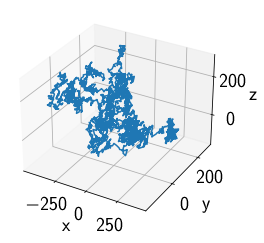

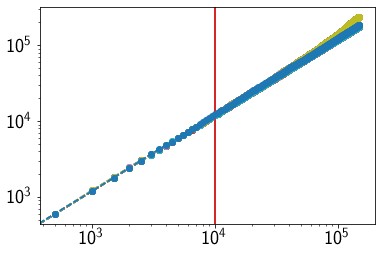

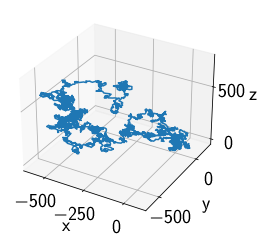

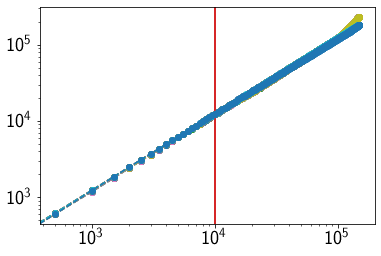

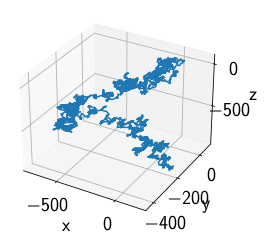

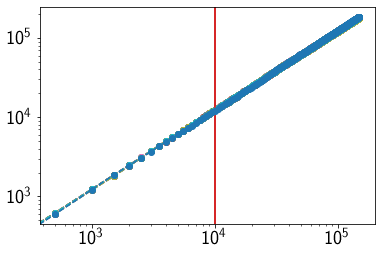

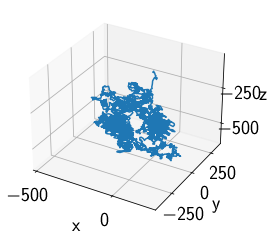

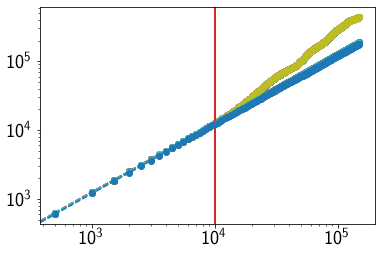

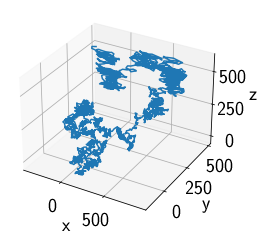

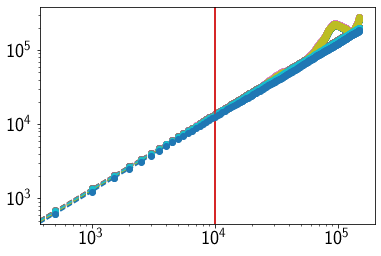

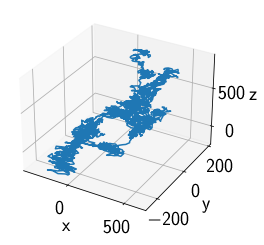

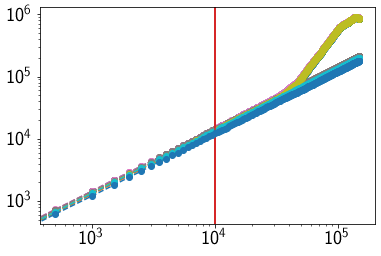

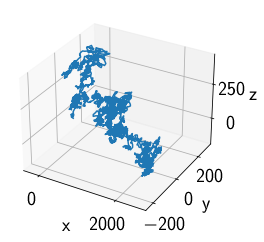

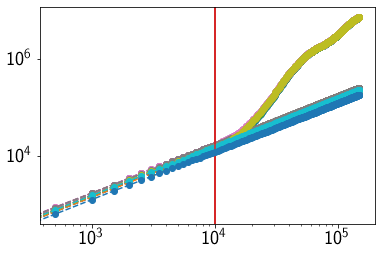

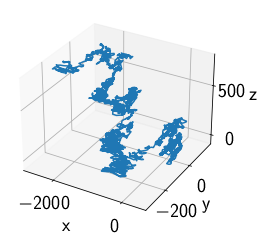

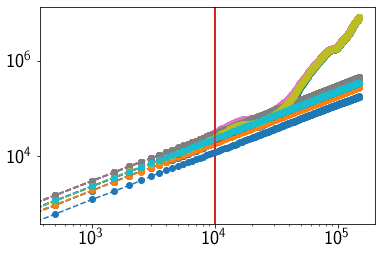

In [20]:
def fit(time, D):
    return 2.0 * D * time

ppp = 10 # Points per period

particles = 10000
#cutoff = 9999999
limit = 1e4

msd_x = np.empty([1,1000])
msd_z = np.empty([1,1000])

for job_name in job_names:
    
    D_osc = []
    std_osc = []
    D_z = []
    
    for i in range(8):
        j = i+1

        with open('../parameter_files/params_dpd_osc.csv') as f:
            line = f.readlines()[j]
            line = line.split(',')
        
        freq = float(line[0])
        t = 1 / freq
    
        h5file = h5py.File(data_dir + 'le_traj_' + job_name + '[' + str(j) +']/trajectory.h5', 'r')

        r = h5file['particles/atoms/position/value']#[-cutoff:]
        vel = h5file['particles/atoms/velocity/value']#[-cutoff:]
        image = h5file['particles/atoms/image/value']#[-cutoff:]
        le_offset = h5file['particles/atoms/lees_edwards_offset/value']#[-cutoff:]
        edges = h5file['particles/atoms/box/edges/'][:]
        r_time = h5file['particles/atoms/position/time']#[-cutoff:]
    
        print("Length of array:", np.shape(r_time))
    
        time = r_time-r_time[0]
        
        periods = int(np.round(time[-1] * freq))
        ana_periods = periods -1
        samples = np.arange(ana_periods, 0, -1)
        
        print(periods, ana_periods, freq, t)
    
        # Get trajectory of all particles and unwrap them
        # Add the LE offset

        pos = r + image*edges[None,None,:]
        pos[:,:,0] -= le_offset

        selected_part = np.random.randint(0, particles)
    
        x_traj_single = pos[:, selected_part, 0]
        y_traj_single = pos[:, selected_part, 1]
        z_traj_single = pos[:, selected_part, 2]
    
        plt.figure()
        ax = plt.axes(projection = '3d')
        ax.plot(x_traj_single, y_traj_single, z_traj_single)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        
        plt.figure()
        
        for idx_start in np.arange(0,ppp):
            idx_stop = ppp * ana_periods + idx_start
            print(idx_start, idx_stop)
            
            time = r_time[idx_start:idx_stop]-r_time[idx_start]
            
            time = r_time[idx_start:idx_stop]
            time = time[::ppp]
            time = time - time[0]
            
            x_traj_all = pos[idx_start:idx_stop, :, 0][::ppp]
            y_traj_all = pos[idx_start:idx_stop, :, 1][::ppp]
            z_traj_all = pos[idx_start:idx_stop, :, 2][::ppp]
            msd_x_all = np.empty_like(x_traj_all)
            msd_y_all = np.empty_like(y_traj_all)
            msd_z_all = np.empty_like(z_traj_all)
            
            #print(idx_start, idx_stop)
            #print(time[::ppp])
            
            for k in range(particles):
                for l in range(len(x_traj_all)):
                    msd_x_all[l,k] = (x_traj_all[l,k] - x_traj_all[0,k]) ** 2.
                    msd_y_all[l,k] = (y_traj_all[l,k] - y_traj_all[0,k]) ** 2.
                    msd_z_all[l,k] = (z_traj_all[l,k] - z_traj_all[0,k]) ** 2.

            msd_x_mean = np.mean(msd_x_all, axis=1)
            msd_y_mean = np.mean(msd_y_all, axis=1)
            msd_z_mean = np.mean(msd_z_all, axis=1)
            
            print("Shape:", np.shape(time), np.shape(msd_x_mean))
            
            idx = np.searchsorted(time, limit)
            
            D, cov = curve_fit(fit, time[:idx], msd_x_mean[:idx], sigma=1/np.sqrt(samples)[:idx])
            D_osc = np.append(D_osc, D)
            std_osc = np.append(std_osc, np.sqrt(cov))
            
            plt.plot(time, msd_x_mean, 'o--', label="MSD x")
            plt.plot(time, fit(time, D), 'o--', label="MSD x")
            
            plt.axvline(limit, color='tab:red')
            
            D, cov = curve_fit(fit, time[:idx], msd_z_mean[:idx], sigma=1/np.sqrt(samples)[:idx])
            D_z = np.append(D_z, D)
            
            #plt.legend()
            plt.loglog()
    
        plt.plot(time, msd_z_mean, 'o--', label="MSD x")
    
    #np.save('diffcoeff_osc_z_' + job_name, D_z)
    #np.save('diffcoeff_osc_x_' + job_name, D_osc)

plt.show()

0
1
2
3
4
5
6
7


<Figure size 432x288 with 0 Axes>

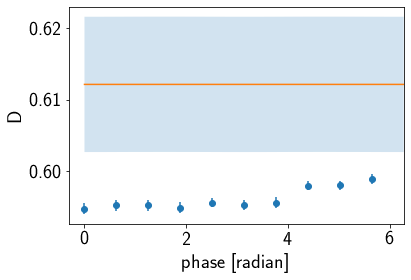

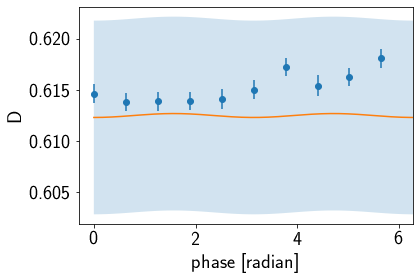

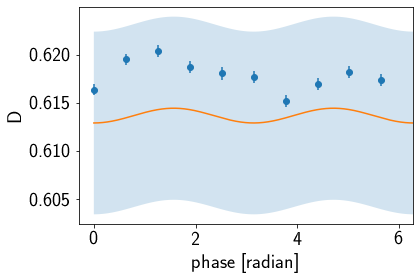

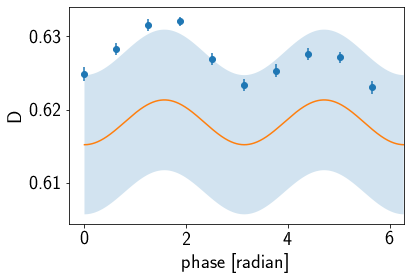

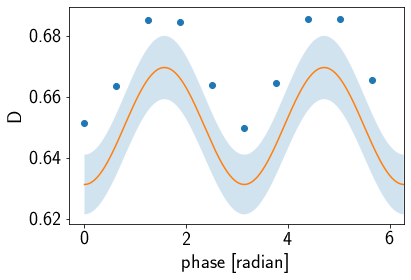

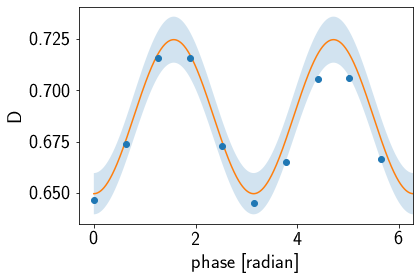

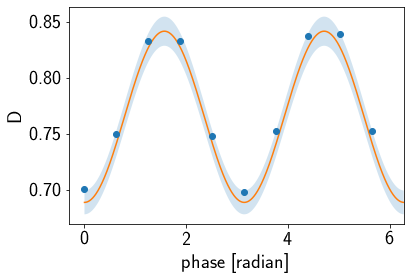

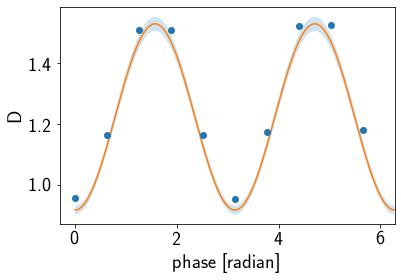

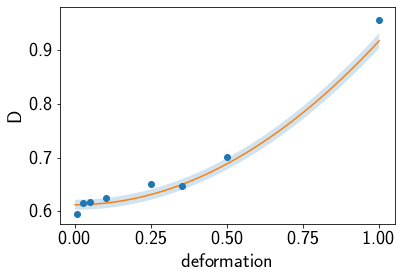

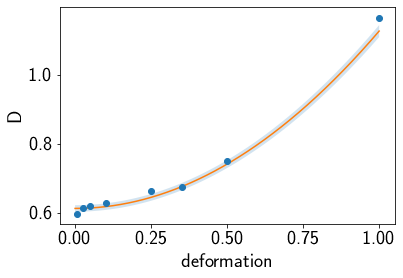

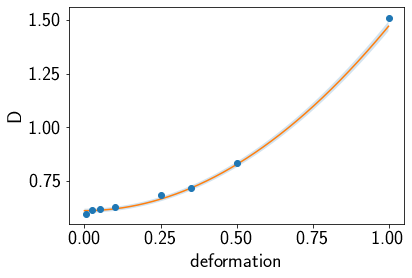

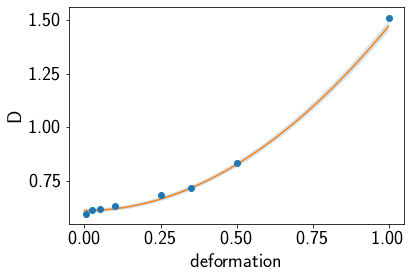

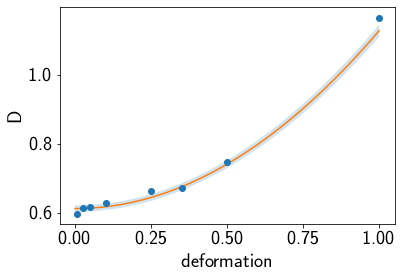

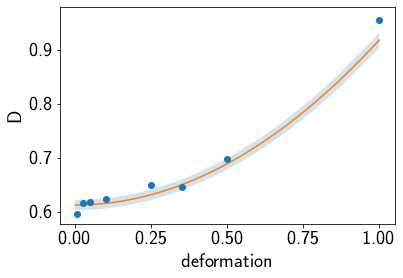

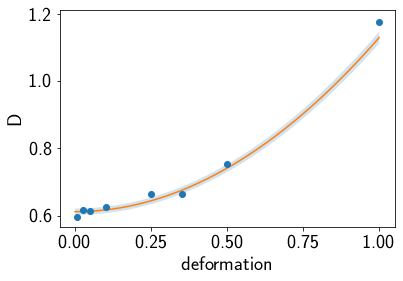

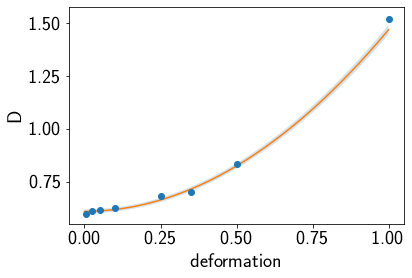

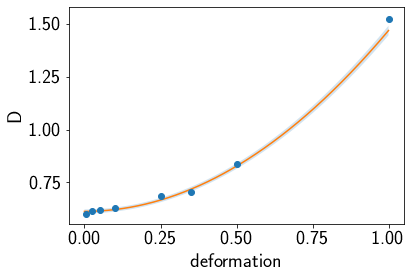

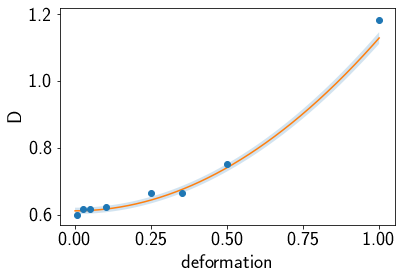

In [21]:
#D_eff = D * (1. + strain**2. / 2. * (2. * np.sin(phase)**2. + 1.))

phase = np.linspace(0, 2.0*np.pi, 11)[:-1]
ampl = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0, 2.])
strain = ampl / 2

phase_conti = np.linspace(0, 2.0*np.pi, 1000)[:-1]
strain_conti = np.linspace(0, 1, 1000)[:-1]

D = D_z.mean()

fig = plt.figure()

for i in range(8):
    print(i)
    fig, ax1 = plt.subplots()
    ax1.set_ylabel("D")
    ax1.set_xlabel("phase [radian]")
    ax1.set_xlim(-0.3,2.*np.pi)
    ax1.errorbar(phase, D_osc[i*10:(i+1)*10], yerr=std_osc[i*10:(i+1)*10], fmt='o', label = "Measurement")
    #ax2 = ax1.twinx()
    ax1.set_ylabel("D")
    ax1.set_xlabel("phase [radian]")
    ax1.plot(phase_conti, D * (1. + strain[i]**2. / 2. * (2. * np.sin(phase_conti)**2. + 1.)), label = "Prediction")
    ax1.fill_between(phase_conti, 
                     (D-D_z.std()) * (1. + strain[i]**2. / 2. * (2. * np.sin(phase_conti)**2. + 1.)), 
                     (D+D_z.std()) * (1. + strain[i]**2. / 2. * (2. * np.sin(phase_conti)**2. + 1.)),
                     alpha=0.2)

for i in range(10):
    fig, ax1 = plt.subplots()
    ax1.set_ylabel("D")
    ax1.set_xlabel("deformation")
    ax1.errorbar(strain, D_osc[i::ppp], yerr=std_osc[i::ppp], fmt='o', label = "Measurement")
    #ax2 = ax1.twinx()
    ax1.plot(strain_conti, D * (1. + strain_conti**2. / 2. * (2. * np.sin(phase[i])**2. + 1.)), label = "Prediction")
    ax1.fill_between(strain_conti,
                    (D-D_z.std()) * (1. + strain_conti**2. / 2. * (2. * np.sin(phase[i])**2. + 1.)),
                    (D+D_z.std()) * (1. + strain_conti**2. / 2. * (2. * np.sin(phase[i])**2. + 1.)),
                    alpha=0.2)